In [25]:
import argparse
import copy
import gc
import math
import os
import random
import time
import h5py

import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn

from matplotlib.pyplot import figure
from torch.utils.data import DataLoader

In [26]:
parser = argparse.ArgumentParser()

experimentName = 'DCAE.DC.DC.MA.WGAN-GC'

parser.add_argument("--DATASETPATH", type=str, default=os.path.expanduser('~/workspace/data/mimic-iii-processed/BINARY.h5'), help="Dataset file")

parser.add_argument("--n_epochs", type=int, default=100, help="number of epochs of training")
parser.add_argument("--n_epochs_ae", type=int, default=100, help="number of epochs of autoencoder training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.001, help="adam: learning rate")
parser.add_argument("--n_cpu", type=int, default=32, help="number of cpu threads to use during batch generation")
parser.add_argument('--n_critic', type=int, default=5, help='number of Discriminator iterations per each Generator iteration')
parser.add_argument('--clamp', type=float, default=0.01, help='weight clipping value')
parser.add_argument("--cuda", type=bool, default=True, help="CUDA activation")
parser.add_argument("--latent_dim", type=int, default=128, help="dimensionality of the latent space")

parser.add_argument("--expPATH", type=str, default=os.path.expanduser('~/workspace/experiments/pytorch/model/{}'.format(experimentName)), help="Training status")

opt = parser.parse_args([])
print(opt)

Namespace(DATASETPATH='/home/mohi/workspace/data/mimic-iii-processed/BINARY.h5', batch_size=64, clamp=0.01, cuda=True, expPATH='/home/mohi/workspace/experiments/pytorch/model/DCAE.DC.DC.MA.WGAN-GC', latent_dim=128, lr=0.001, n_cpu=32, n_critic=5, n_epochs=100, n_epochs_ae=100)


In [ ]:
######################
### Initialization ###
######################

# Create experiments DIR
if not os.path.exists(opt.expPATH):
    os.system('mkdir {0}'.format(opt.expPATH))

# opt.seed = 1024 # fix seed
opt.seed = random.randint(1, 10000)

print('Random Seed: {}'.format(opt.seed))
random.seed(opt.seed)
torch.manual_seed(opt.seed)
np.random.seed(opt.seed)
cudnn.benchmark = True

if torch.cuda.is_available() and not opt.cuda:
    print("WARNING: You have a CUDA device BUT it is not in use...")

device = torch.device("cuda:0" if opt.cuda else "cpu")
print('using "{}" as the tensor processor'.format(device))

In [ ]:
#################################
### Reading Dataset from File ###
#################################

input_data = None
with h5py.File(opt.DATASETPATH, 'r') as hf:
    input_data = hf.get('dataset')[()]

sample_size = input_data.shape[0]
feature_size = input_data.shape[1]

In [ ]:
#####################
### Dataset Model ###
#####################

class EHRDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.sample_size = dataset.shape[0]
        self.feature_size = dataset.shape[1]

    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, idx):
        return self.dataset[idx]

In [ ]:
##########################
### Dataset Processing ###
##########################

train_data = input_data[:int(0.8 * sample_size)]
test_data = input_data[int(0.8 * sample_size):]
print('total samples: {}, features: {}'.format(sample_size, feature_size))
print('training data shape: {}, testing data shape: {}, dataset type: {}'.format(train_data.shape, test_data.shape, input_data.dtype))

In [ ]:
training_dataloader = DataLoader(
    EHRDataset(dataset=train_data),
    batch_size=opt.batch_size,
    shuffle=True,
    num_workers=opt.n_cpu
)

testing_dataloader = DataLoader(
    EHRDataset(dataset=test_data),
    batch_size=opt.batch_size,
    shuffle=True,
    num_workers=opt.n_cpu
)

In [ ]:
########################
### AutoEncoder Loss ###
########################

class AutoEncoderLoss(nn.Module):
    def __init__(self):
        super(AutoEncoderLoss, self).__init__()

    def forward(self, input, target):
        epsilon = 1e-12
        term = target * torch.log(input + epsilon) + (1. - target) * torch.log(1. - input + epsilon)
        return -torch.sum(term)

In [ ]:
#########################
### AutoEncoder Model ###
#########################

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=8, kernel_size=5, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(in_channels=8, out_channels=16, kernel_size=5, stride=2, padding=1),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, stride=3, padding=1),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=8, stride=3, padding=0),
            nn.Tanh(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=8, stride=3, padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=32, out_channels=16, kernel_size=5, stride=3, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=16, out_channels=8, kernel_size=5, stride=2, padding=1),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=8, out_channels=1, kernel_size=5, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def encode(self, x):
        return self.encoder(x.view(-1, 1, feature_size))

    def decode(self, x):
        return torch.squeeze(self.decoder(x.view(-1, 64, 28)))

    def forward(self, x):
        return self.decode(self.encode(x))

In [ ]:
############################
### Model Initialization ###
############################

gc.collect()
torch.cuda.empty_cache()

autoencoder = Autoencoder().cuda() if opt.cuda else Autoencoder()
optimizer_A = torch.optim.Adam(autoencoder.parameters(), lr=opt.lr)

In [ ]:
#####################################
###### AutoEncoder Training #########
#####################################

criterion = AutoEncoderLoss()

if False:
    for epoch in range(opt.n_epochs_ae):
        train_loss = 0
        autoencoder.train()
        for batch in training_dataloader:
            batch = batch.to(device)
            gen_batch = autoencoder(batch)
            loss_A = criterion(gen_batch, batch)
            optimizer_A.zero_grad()
            loss_A.backward()
            optimizer_A.step()
            train_loss += loss_A

        errors = 0
        test_loss = 0
        autoencoder.eval()
        for batch in testing_dataloader:
            batch = batch.to(device)
            gen_batch = autoencoder(batch)
            test_loss += criterion(gen_batch, batch)

            gen_batch = gen_batch.round()
            diff = torch.abs(gen_batch - batch).view(-1).detach().cpu().numpy()
            wrong_digits = diff[diff > 0.5]
            errors += len(wrong_digits)
        print("[Epoch {:3d}/{:3d}] [Training Loss: {:10.2f}] [Testing Loss: {:10.2f}] [errors: {:6d}]".format(epoch + 1, opt.n_epochs_ae, train_loss, test_loss, errors), flush=True)
    torch.save(autoencoder.state_dict(), opt.expPATH + '/autoencoder.model')
else:
    autoencoder.load_state_dict(torch.load(opt.expPATH + '/autoencoder.model'))
    autoencoder.eval()

In [ ]:
errors = 0
for batch in testing_dataloader:
    batch = batch.to(device)
    gen_batch = autoencoder(batch).round()
    diff = torch.abs(gen_batch - batch).view(-1).detach().cpu().numpy()
    wrong_digits = diff[diff > 0.5]
    errors += len(wrong_digits)
print("total number of wrong digits: {}".format(errors))

In [ ]:
#############################
### Generator Model ###
#############################

# Output should be 64 * 28
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.ConvTranspose1d(opt.latent_dim, 256, 7, 2, 0),
            nn.BatchNorm1d(256, eps=0.0001, momentum=0.01),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(256, 128, 4, 2, 1),
            nn.BatchNorm1d(128, eps=0.0001, momentum=0.01),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(128, 64, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x.view(-1, opt.latent_dim, 1))

In [ ]:
###########################
### Discriminator Model ###
###########################

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        ndf = 16

        self.model = nn.Sequential(
            # minibatch averaging
            nn.Linear(2 * feature_size, feature_size),

            # input is (nc) x 64 x 64
            nn.Conv1d(1, ndf, 8, 4, 1),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf) x 32 x 32
            nn.Conv1d(ndf, ndf * 2, 8, 4, 1),
            nn.BatchNorm1d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf*2) x 16 x 16
            nn.Conv1d(ndf * 2, ndf * 4, 8, 4, 1),
            nn.BatchNorm1d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf*4) x 8 x 8
            nn.Conv1d(ndf * 4, ndf * 8, 8, 4, 1),
            nn.BatchNorm1d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf*8) x 4 x 4
            nn.Conv1d(ndf * 8, 1, 3, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, x):
        # minibatch averaging
        x_mean = torch.mean(x, 0).repeat(x.shape[0], 1)
        x = torch.cat((x, x_mean), 1)
        return self.model(x.view(-1, 1, 2 * feature_size)).view(-1, 1)

In [17]:
############################
### Model Initialization ###
############################

gc.collect()
torch.cuda.empty_cache()

generator = Generator().cuda() if opt.cuda else Generator()
discriminator = Discriminator().cuda() if opt.cuda else Discriminator()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr)

In [18]:
if True:
    batches_done = 0

    discriminator.train()
    generator.train()

    for epoch in range(opt.n_epochs):
        epoch_start = time.time()
        for _ in range(opt.n_critic):
            for batch in training_dataloader:
                # ---------------------
                #  Train Discriminator
                # ---------------------
                batch = batch.to(device)

                for dp in discriminator.parameters():
                    dp.requires_grad = True

                optimizer_D.zero_grad()

                z = torch.randn(batch.shape[0], opt.latent_dim, device=device)
                fake_batch = autoencoder.decode(generator(z))
                loss_D = torch.mean(discriminator(batch), dim=0) - torch.mean(discriminator(fake_batch.detach()), dim=0)
                loss_D.backward()

                optimizer_D.step()

                for dp in discriminator.parameters():
                    dp.data.clamp_(-opt.clamp, opt.clamp)

                if batches_done % opt.n_critic == 0:
                    # -----------------
                    #  Train Generator
                    # -----------------
                    for dp in discriminator.parameters():
                        dp.requires_grad = False

                    optimizer_G.zero_grad()

                    z = torch.randn(batch.shape[0], opt.latent_dim, device=device)
                    fake_batch = autoencoder.decode(generator(z))
                    loss_G = torch.mean(discriminator(fake_batch), dim=0)
                    loss_G.backward()

                    optimizer_G.step()

                batches_done += 1
                if batches_done % (100 * opt.n_critic) == 0:
                    print('[Epoch {:3d}/{:3d}] [Batch {:4d}/{:4d}] [D loss: {:.6f}] [G loss: {:.6f}]'.format(epoch + 1, opt.n_epochs, batches_done % (opt.n_critic * len(training_dataloader)), opt.n_critic * len(training_dataloader), loss_D.item(), loss_G.item()))

        print('[Epoch {:3d}/{:3d}] [Time: {:.2f}] [D loss: {:.6f}] [G loss: {:.6f}]'.format(epoch + 1, opt.n_epochs, time.time() - epoch_start, loss_D.item(), loss_G.item()))

    torch.save(generator.state_dict(), opt.expPATH + '/generator.model')
    torch.save(discriminator.state_dict(), opt.expPATH + '/discriminator.model')
else:
    generator.load_state_dict(torch.load(opt.expPATH + '/generator.model'))
    discriminator.load_state_dict(torch.load(opt.expPATH + '/discriminator.model'))

[Epoch   1/100] [Batch  500/2910] [D loss: -0.016658] [G loss: 0.508330]
[Epoch   1/100] [Batch 1000/2910] [D loss: -0.016832] [G loss: 0.508416]
[Epoch   1/100] [Batch 1500/2910] [D loss: -0.016888] [G loss: 0.508444]
[Epoch   1/100] [Batch 2000/2910] [D loss: -0.016912] [G loss: 0.508456]
[Epoch   1/100] [Batch 2500/2910] [D loss: -0.016929] [G loss: 0.508465]
[Epoch   1/100] [Time: 33.44] [D loss: -0.016936] [G loss: 0.508468]
[Epoch   2/100] [Batch   90/2910] [D loss: -0.016937] [G loss: 0.508468]
[Epoch   2/100] [Batch  590/2910] [D loss: -0.016943] [G loss: 0.508471]
[Epoch   2/100] [Batch 1090/2910] [D loss: -0.016947] [G loss: 0.508473]
[Epoch   2/100] [Batch 1590/2910] [D loss: -0.016950] [G loss: 0.508475]
[Epoch   2/100] [Batch 2090/2910] [D loss: -0.016953] [G loss: 0.508477]
[Epoch   2/100] [Batch 2590/2910] [D loss: -0.016956] [G loss: 0.508478]
[Epoch   2/100] [Time: 33.37] [D loss: -0.016956] [G loss: 0.508478]
[Epoch   3/100] [Batch  180/2910] [D loss: -0.016956] [G lo

In [19]:
autoencoder.eval()
generator.eval()
discriminator.eval()

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=2142, out_features=1071, bias=True)
    (1): Conv1d(1, 16, kernel_size=(8,), stride=(4,), padding=(1,))
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv1d(16, 32, kernel_size=(8,), stride=(4,), padding=(1,))
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv1d(32, 64, kernel_size=(8,), stride=(4,), padding=(1,))
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv1d(64, 128, kernel_size=(8,), stride=(4,), padding=(1,))
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv1d(128, 1, kernel_size=(3,), stride=(1,))
    (13): Sigmoid()
  )
)

In [23]:
num_fake_batches = 80
fake_data = torch.zeros((0, feature_size), device='cpu')
for _ in range(num_fake_batches):
  z = torch.randn(opt.batch_size, 128, device=device)
  generated_batch = generator(z)
  fake_batch = torch.squeeze(autoencoder.decode(generator(z).unsqueeze(dim=2)))
  fake_data = torch.cat((fake_data, fake_batch.round().to('cpu')), 0)
np.save(os.path.join(opt.expPATH, "synthetic.npy"), fake_data.detach().cpu().numpy(), allow_pickle=False)

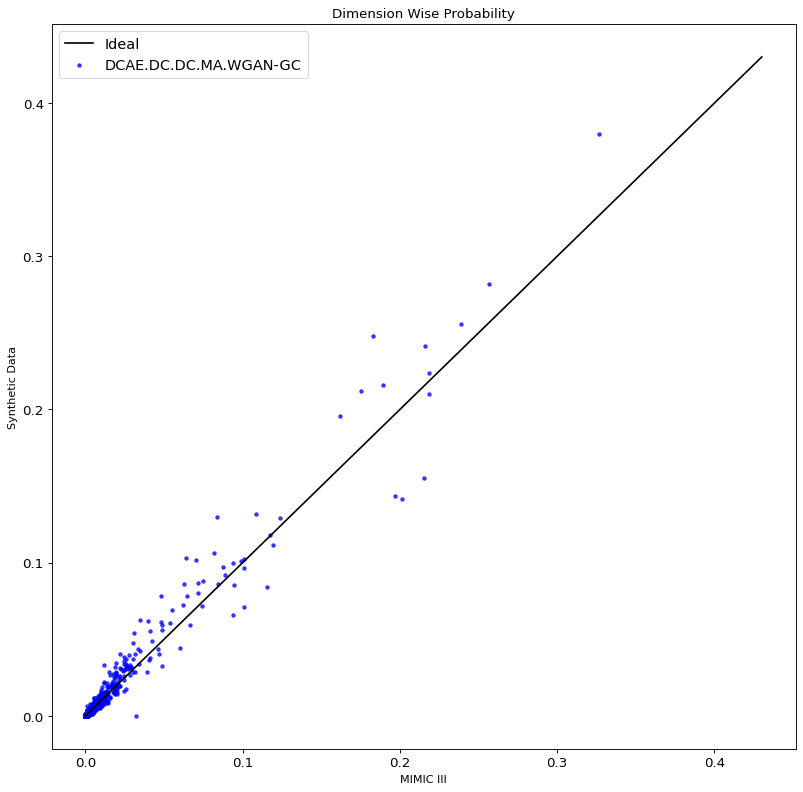

In [28]:
# gen_samples = fake_data.detach().cpu().numpy()
gen_samples = np.load(os.path.join(opt.expPATH, "synthetic.npy"), allow_pickle=False)

# load real data
real_samples = train_data[0:gen_samples.shape[0], :]

# dimenstion wise probability
prob_real = np.mean(real_samples, axis=0)
prob_syn = np.mean(gen_samples, axis=0)

figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.scatter(prob_real, prob_syn, c="b", alpha=0.7, label="DCAE.DC.DC.MA.WGAN-GC", s=9)
x_max = max(np.max(prob_real), np.max(prob_syn))
x = np.linspace(0, x_max + 0.05, 1000)
p2 = plt.plot(x, x, linestyle='-', color='k', label="Ideal")  # solid
plt.tick_params(labelsize=12)
plt.legend(loc=2, prop={'size': 13})
plt.title('Dimension Wise Probability')
plt.xlabel('MIMIC III')
plt.ylabel('Synthetic Data')
plt.show()